In [1]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})
import numpy as np

<Figure size 432x288 with 0 Axes>

In [41]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [196]:
import scipy.optimize

In [2]:
def ellipse(a, b, t):
    x = a * np.cos(t)
    y = b * np.sin(t)
    return x, y

In [3]:
t = np.linspace(0, 2*np.pi, 100)

In [4]:
x0, y0 = ellipse(1, 1, t)
x1, y1 = ellipse(1, 0.5, t)

t2 = np.linspace(0, 10*np.pi, 500)
a_t = t2/t2.max()
b_t = t2/t2.max()
x2, y2 = ellipse(a_t, b_t, t2)

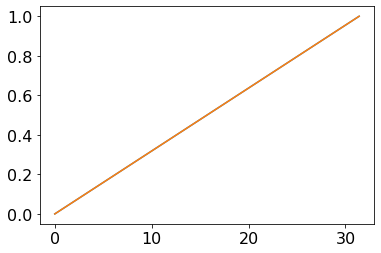

In [5]:
plt.plot(t2, a_t)
plt.plot(t2, b_t)

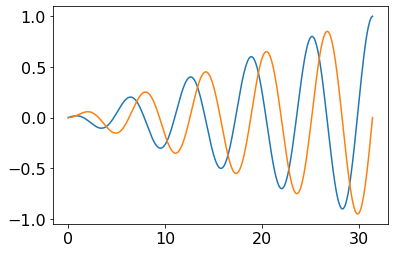

In [6]:
plt.plot(t2, x2)
plt.plot(t2, y2)

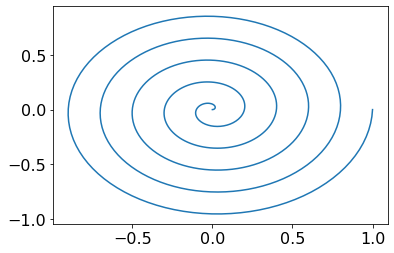

In [7]:
plt.plot(x2, y2)

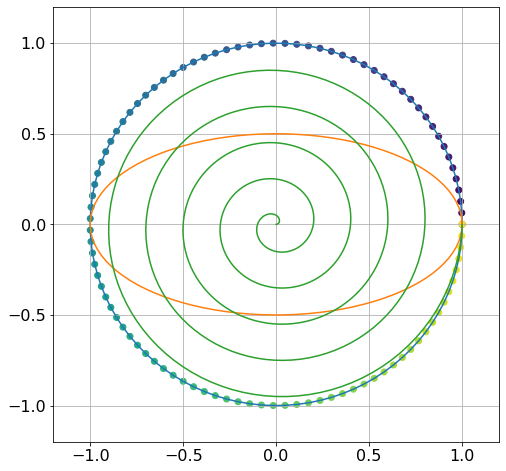

In [8]:
plt.figure(figsize=(8,8))
plt.plot(x0, y0)
plt.plot(x1, y1)
plt.scatter(x0, y0, c=t)
plt.plot(x2, y2)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.grid()

In [9]:
t2 = np.linspace(0, 2*np.pi, 100)
a_t = t2/t2.max()
b_t = t2/t2.max()

xs=[]
ys=[]
for i in range(len(t2[::4])):
    x_, y_ = ellipse(a_t[i], b_t[i], t2)
    xs.append(x_)
    ys.append(y_)

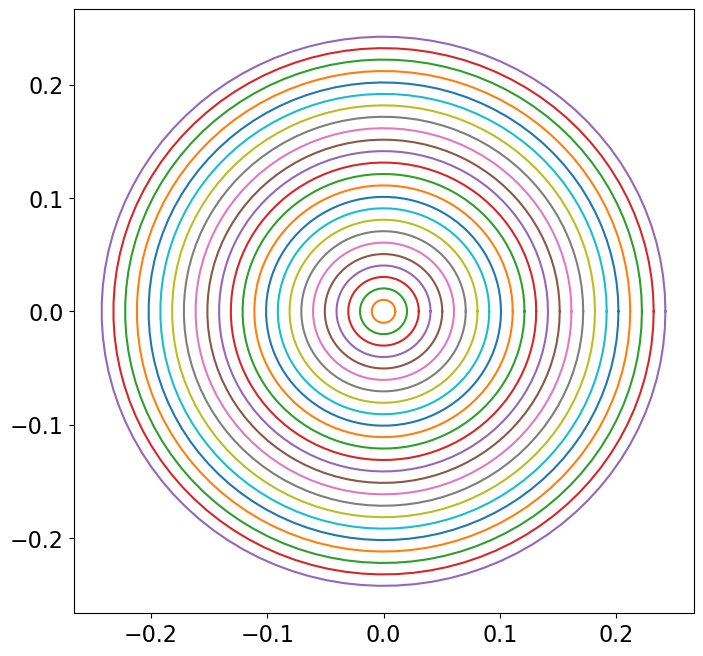

In [10]:
plt.figure(figsize=(8,8), dpi=100)
for i in range(len(xs)):
    plt.plot(xs[i], ys[i])

In [11]:
import pycbc.waveform

In [12]:
2**14

16384

In [21]:
hp, hc = pycbc.waveform.get_td_waveform(approximant='EccentricTD', mass1=30, mass2=30, f_lower=20, delta_t=1/16384, eccentricity=3e-2, distance=1e-19)
# hp, hc = pycbc.waveform.get_td_waveform(approximant='EccentricTD', mass1=30, mass2=30, f_lower=20, delta_t=1/8192, eccentricity=3e-1, distance=1e-19)
# hp, hc = pycbc.waveform.get_td_waveform(approximant='SEOBNRv4', mass1=30, mass2=30, f_lower=20, delta_t=1/8192, distance=1e-19)
times = hp.sample_times.numpy()

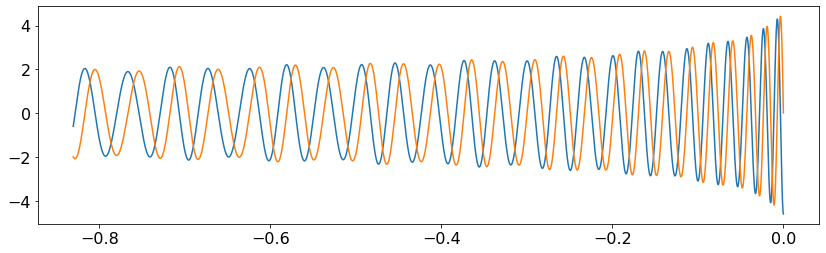

In [22]:
plt.figure(figsize=(14, 4))
plt.plot(times, hp)
plt.plot(times, hc)

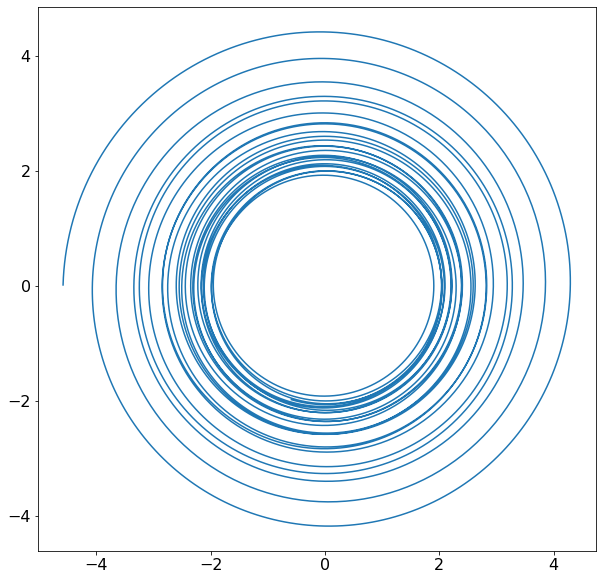

In [23]:
plt.figure(figsize=(10,10))
plt.plot(hp, hc)

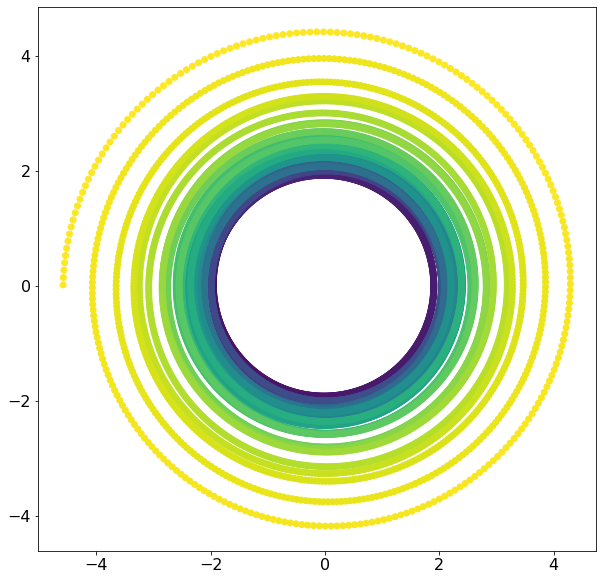

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(hp, hc, c=hp.sample_times)

In [25]:
phase = pycbc.waveform.phase_from_polarizations(hp, hc)

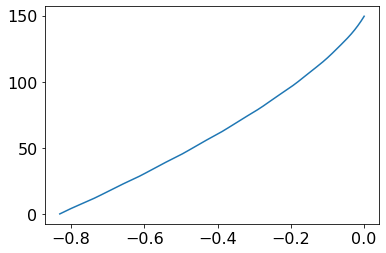

In [26]:
plt.plot(phase.sample_times, phase)

# try to circularise

In [182]:
hp_ecc, hc_ecc = pycbc.waveform.get_td_waveform(approximant='EccentricTD', mass1=30, mass2=30, f_lower=15, delta_t=1/16384, eccentricity=9e-2, distance=1e-19)
# hp_ecc, hc_ecc = pycbc.waveform.get_td_waveform(approximant='EccentricTD', mass1=30, mass2=30, f_lower=15, delta_t=1/16384, eccentricity=1e-3, distance=1e-19)
times = hp_ecc.sample_times.numpy()

phi_ecc = pycbc.waveform.phase_from_polarizations(hp_ecc, hc_ecc)

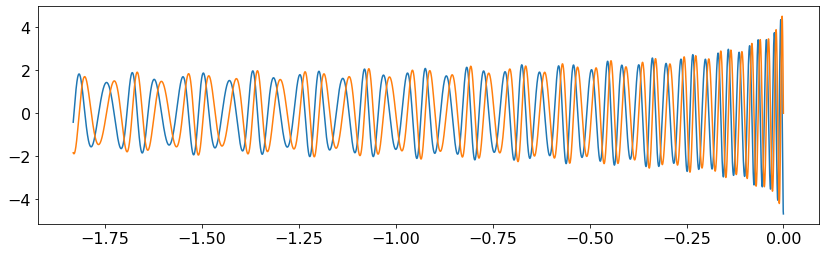

In [183]:
plt.figure(figsize=(14,4))
plt.plot(times, hp_ecc)
plt.plot(times, hc_ecc)

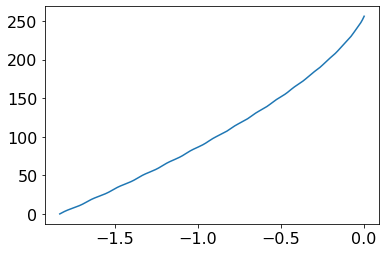

In [184]:
plt.plot(times, phi_ecc)

for the 2,2 mode the gw frequency is 2 * orbital frequency.

the 2,2 mode gw phase is 2 * orbital phase

one orbit is $2 \pi$ rad

the number of orbits between two phase values is 

$$
\frac{\phi(t_1) - \phi(t_0)}{2\pi}
$$

$$
\phi_{orb} = \phi_{22} / 2
$$

the number of orbits between two GW phase values is 

$$
\frac{\phi(t_1) - \phi(t_0)}{4\pi}
$$

??

In [185]:
# from the GW phase let's get the times of the orbits
# i.e. we start at 0 phase and start adding 4pi rad and note the times

In [186]:
def get_times_of_orbit(t, p, max_orbits=10):
    """
    need a smarter way to extract all orbits
    """
    i_p_of_t = IUS(t, p)
    i_t_of_p = IUS(p, t)
    
    start_times = []
    start_phis = []
    
    t0 = t[0]
    phi0 = i_p_of_t(t0)
    
    start_times.append(t0)
    start_phis.append(phi0)
    
    for i in range(1, max_orbits):
        t_ = i_t_of_p(start_phis[i-1] + 4*np.pi)
        phi_ = i_p_of_t(t_)
        
        start_times.append(t_)
        start_phis.append(phi_)
    return np.array(start_times), np.array(start_phis)

In [187]:
start_times, start_phis = get_times_of_orbit(times, phi_ecc, max_orbits=10)

In [188]:
start_times

array([-1.83251953, -1.69603895, -1.56913397, -1.45094881, -1.33275835,
       -1.21208016, -1.09471629, -0.98679337, -0.88701445, -0.78683972])

In [189]:
# check that we have 1 orbit between phis
for i in range(1,len(start_phis)):
    np.testing.assert_almost_equal((start_phis[i]-start_phis[i-1])/(4*np.pi), 1)

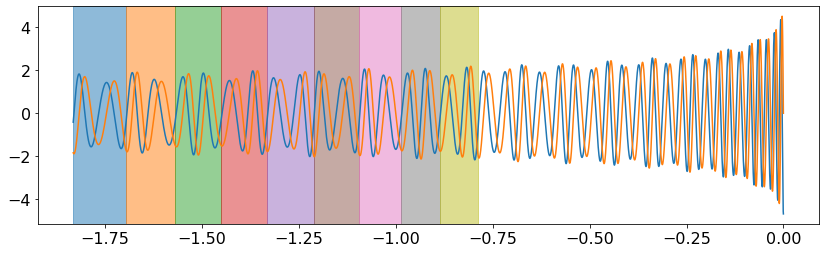

In [190]:
plt.figure(figsize=(14,4))
plt.plot(times, hp_ecc)
plt.plot(times, hc_ecc)
for i in range(len(start_times)-1):
    plt.axvspan(start_times[i], start_times[i+1], color=f"C{i}", alpha=0.5)

In [191]:
# get a list of hp,hc for each orbit
# i_hp_ecc = IUS(times, hp_ecc)
# i_hc_ecc = IUS(times, hc_ecc)
times_orbs=[]
hp_ecc_orbs=[]
hc_ecc_orbs=[]
for i in range(len(start_times)-1):
    mask = (times >= start_times[i]) & (times < start_times[i+1])
    times_orbs.append(times[mask])
    hp_ecc_orbs.append(hp_ecc[mask])
    hc_ecc_orbs.append(hc_ecc[mask])

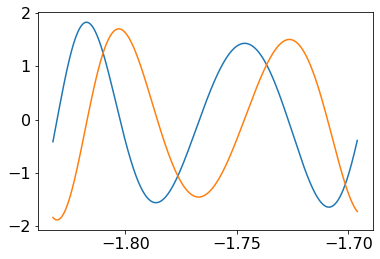

In [192]:
plt.plot(times_orbs[0], hp_ecc_orbs[0])
plt.plot(times_orbs[0], hc_ecc_orbs[0])

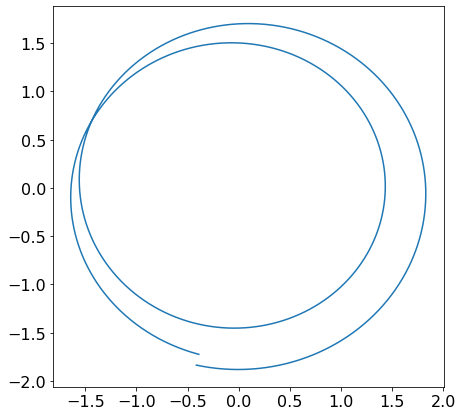

In [193]:
plt.figure(figsize=(7,7))
plt.plot(hp_ecc_orbs[0], hc_ecc_orbs[0])

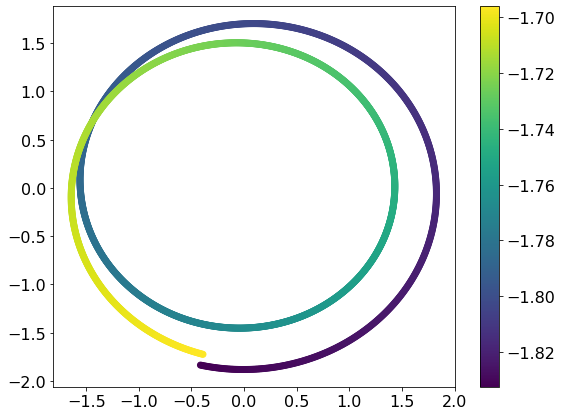

In [194]:
plt.figure(figsize=(9,7))
plt.scatter(hp_ecc_orbs[0], hc_ecc_orbs[0], c=times_orbs[0])
plt.colorbar()

now we want to find a mapping from this to a circle?

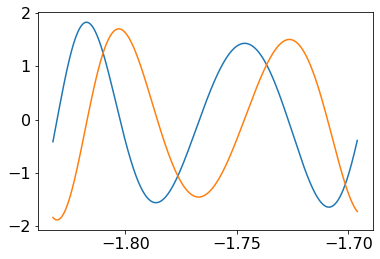

In [195]:
plt.plot(times_orbs[0], hp_ecc_orbs[0])
plt.plot(times_orbs[0], hc_ecc_orbs[0])

or a mapping from this to a circle?

we can fit sin/cos to this

ansatz is

$$
\text{circle} = \text{data} + \text{correction}
$$

this means that


$$
\text{correction} = \text{data} - \text{circle}
$$

is circle just the non-eccentric waveform?

is this the same as Yoshinta? https://arxiv.org/abs/2101.11033

i think it would be different if we instead construct an algorith that minimises the distance to the 'closest' circle averaged over one orbit and use that to define eccentricity from the waveform.

but maybe this ends up being mathetmatically the same as something else?

either way it might be a nice way to build an alternative parameterisation directly from the waveform that can be directly related to a circle?

In [223]:
def f_x_comp(t, a, b):
    return a * np.cos(b*t)

def f_y_comp(t, a, b):
    return a * np.sin(b*t)

In [228]:
popt_hp, pcov_hp = scipy.optimize.curve_fit(f_x_comp, times_orbs[0], hp_ecc_orbs[0])
popt_hc, pcov_hc = scipy.optimize.curve_fit(f_y_comp, times_orbs[0], hc_ecc_orbs[0])

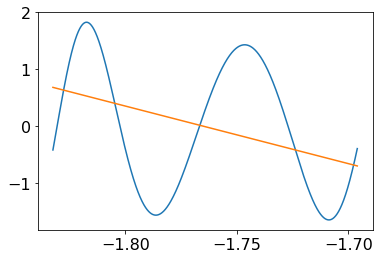

In [230]:
plt.plot(times_orbs[0], hp_ecc_orbs[0])
plt.plot(times_orbs[0], f_x_comp(times_orbs[0], *popt_hp))

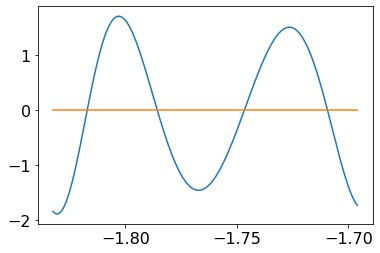

In [229]:
plt.plot(times_orbs[0], hc_ecc_orbs[0])
plt.plot(times_orbs[0], f_y_comp(times_orbs[0], *popt_hc))

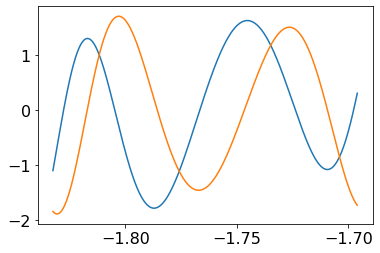

In [232]:
plt.plot(times_orbs[0], hp_ecc_orbs[0]-f_x_comp(times_orbs[0], *popt_hp))
plt.plot(times_orbs[0], hc_ecc_orbs[0]-f_y_comp(times_orbs[0], *popt_hc))

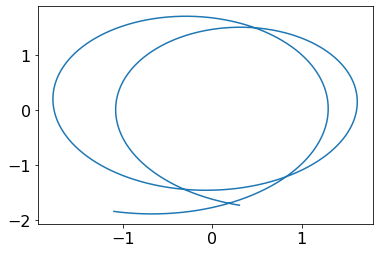

In [233]:
plt.plot(hp_ecc_orbs[0]-f_x_comp(times_orbs[0], *popt_hp), hc_ecc_orbs[0]-f_y_comp(times_orbs[0], *popt_hc))

# compare with non-ecc

In [252]:
def decompose_into_orbits(eccentricity):
    hp_ecc, hc_ecc = pycbc.waveform.get_td_waveform(approximant='EccentricTD', mass1=30, mass2=30, f_lower=15, delta_t=1/16384, eccentricity=eccentricity, distance=1e-19)
    # hp_ecc, hc_ecc = pycbc.waveform.get_td_waveform(approximant='EccentricTD', mass1=30, mass2=30, f_lower=15, delta_t=1/16384, eccentricity=1e-3, distance=1e-19)
    times = hp_ecc.sample_times.numpy()

    amp = pycbc.waveform.amplitude_from_polarizations(hp_ecc, hc_ecc)
    phi_ecc = pycbc.waveform.phase_from_polarizations(hp_ecc, hc_ecc)
    
    phi_ecc = phi_ecc - phi_ecc[0]
    hh = amp * np.exp(-1.j * phi_ecc)
    hh = np.array(hh)
    hp_ecc = np.real(hh)
    hc_ecc = np.imag(hh)
    
    start_times, start_phis = get_times_of_orbit(times, phi_ecc, max_orbits=10)
    
    # get a list of hp,hc for each orbit
    # i_hp_ecc = IUS(times, hp_ecc)
    # i_hc_ecc = IUS(times, hc_ecc)
    times_orbs=[]
    hp_ecc_orbs=[]
    hc_ecc_orbs=[]
    for i in range(len(start_times)-1):
        mask = (times >= start_times[i]) & (times < start_times[i+1])
        times_orbs.append(times[mask])
        hp_ecc_orbs.append(hp_ecc[mask])
        hc_ecc_orbs.append(hc_ecc[mask])
        
    return times_orbs, hp_ecc_orbs, hc_ecc_orbs

In [253]:
times_ecc_orbs, hp_ecc_orbs, hc_ecc_orbs = decompose_into_orbits(eccentricity=9e-2)
times_circ_orbs, hp_circ_orbs, hc_circ_orbs = decompose_into_orbits(eccentricity=1e-3)

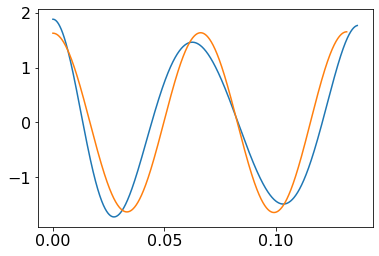

In [259]:
# need to align the circ and the ecc in time and phase...
# maybe this is where just using the ecc waveform would be nice when defining a map to approx circ
# but then we wouldn't have the nice property that we just ADD the correction to a circular waveform
idx = 0
plt.plot(times_ecc_orbs[idx]-times_ecc_orbs[idx][0], hp_ecc_orbs[idx])
plt.plot(times_circ_orbs[idx]-times_circ_orbs[idx][0], hp_circ_orbs[idx])